Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16


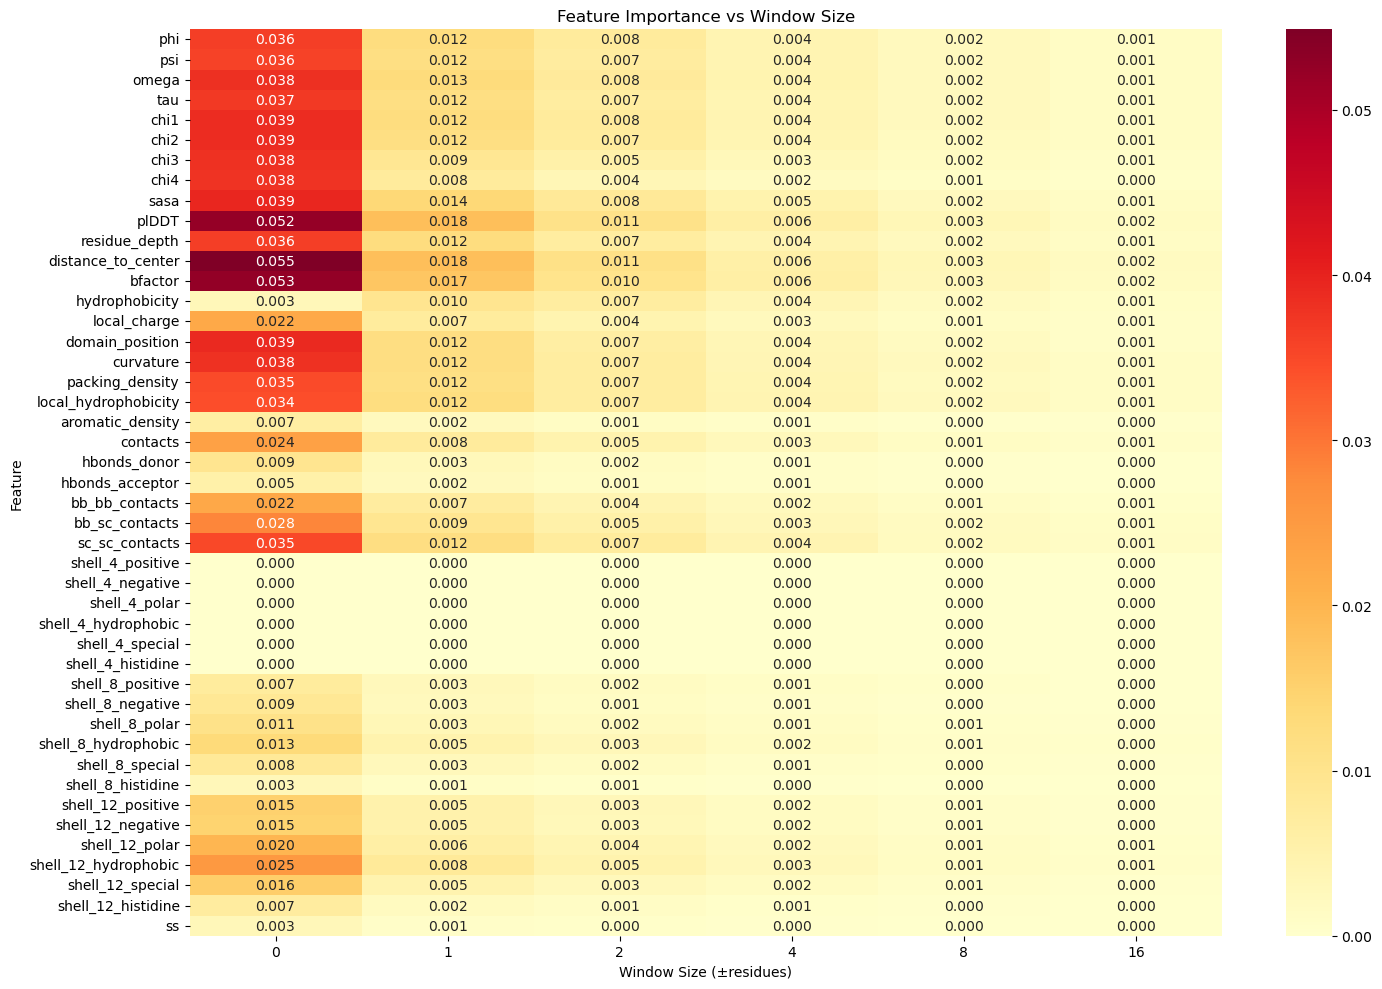


Top 10 features for window size ±0:
distance_to_center: 0.0549
bfactor: 0.0527
plDDT: 0.0525
sasa: 0.0395
domain_position: 0.0392
chi2: 0.0387
chi1: 0.0387
omega: 0.0382
chi3: 0.0381
curvature: 0.0379

Top 10 features for window size ±1:
distance_to_center: 0.0183
plDDT: 0.0183
bfactor: 0.0171
sasa: 0.0137
omega: 0.0128
phi: 0.0124
chi1: 0.0124
residue_depth: 0.0123
local_hydrophobicity: 0.0120
domain_position: 0.0120

Top 10 features for window size ±2:
distance_to_center: 0.0110
plDDT: 0.0106
bfactor: 0.0101
sasa: 0.0082
omega: 0.0078
chi1: 0.0076
phi: 0.0075
chi2: 0.0074
sc_sc_contacts: 0.0073
psi: 0.0072

Top 10 features for window size ±4:
plDDT: 0.0062
bfactor: 0.0061
distance_to_center: 0.0059
sasa: 0.0047
omega: 0.0043
chi1: 0.0043
phi: 0.0042
psi: 0.0041
sc_sc_contacts: 0.0041
local_hydrophobicity: 0.0041

Top 10 features for window size ±8:
distance_to_center: 0.0033
plDDT: 0.0033
bfactor: 0.0032
sasa: 0.0023
omega: 0.0023
phi: 0.0023
chi1: 0.0022
residue_depth: 0.0022
curva

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('../data/processed_features_train_latest.csv')

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    df = process_feature(df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]  # Example window sizes
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(df, size)
    all_importances[size] = importance

# Plot results
plt.figure(figsize=(15, 10))
results_df = pd.DataFrame(all_importances)
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top features for each window size
for size in window_sizes:
    print(f"\nTop 10 features for window size ±{size}:")
    importance = all_importances[size]
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for feature, imp in sorted_features[:10]:
        print(f"{feature}: {imp:.4f}")

Training Set Label Distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Percentage:
label
1    51.887006
0    48.112994
Name: proportion, dtype: float64
Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16


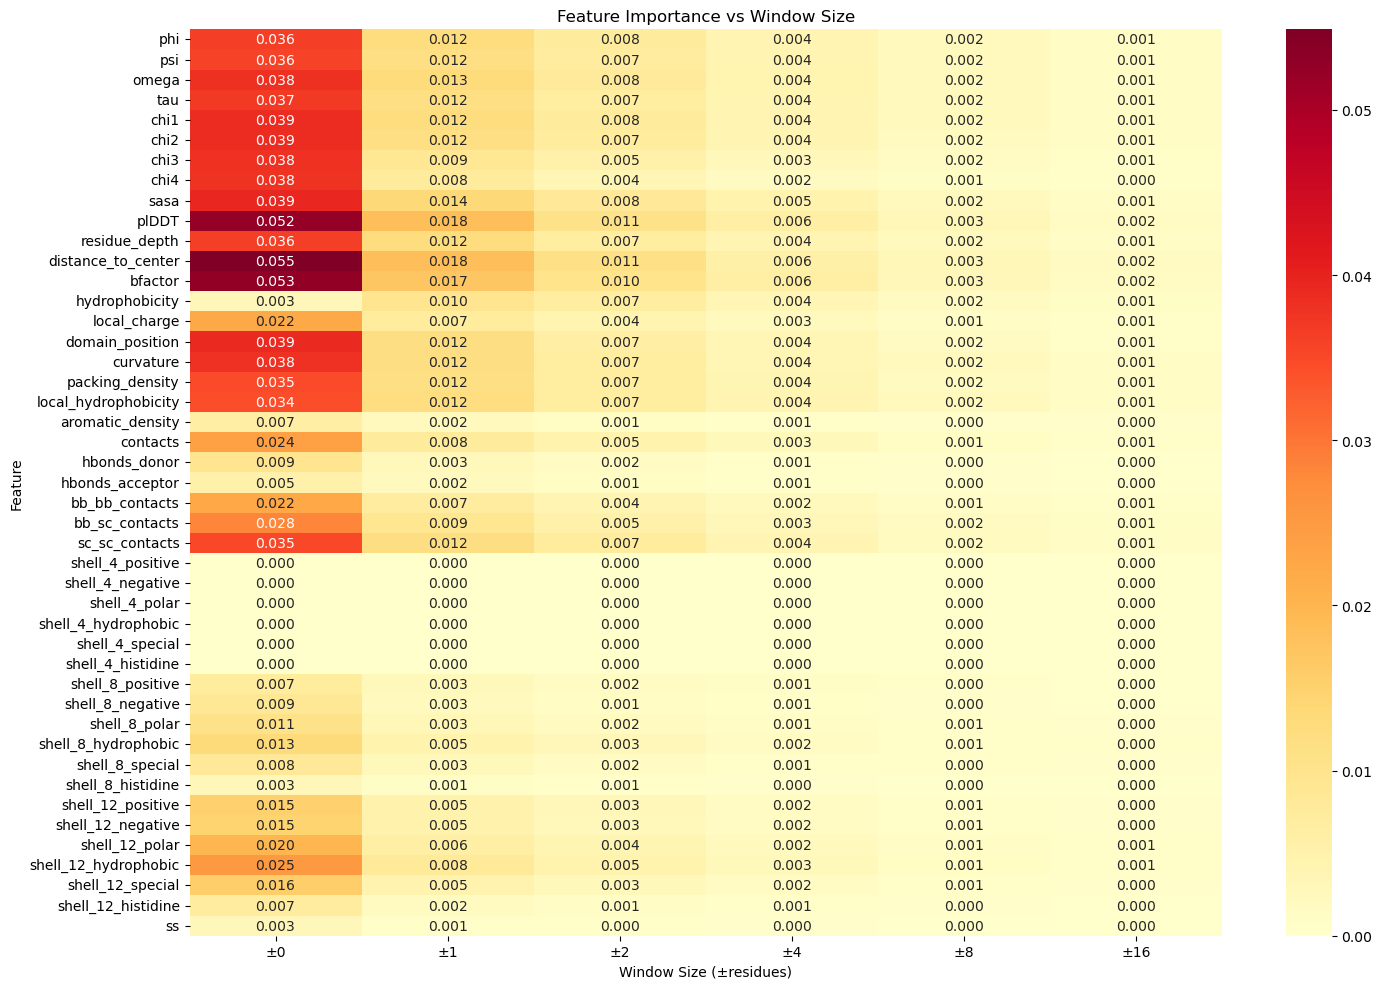


Top 10 features for window size ±0:
distance_to_center: 0.0549
bfactor: 0.0527
plDDT: 0.0525
sasa: 0.0395
domain_position: 0.0392
chi2: 0.0387
chi1: 0.0387
omega: 0.0382
chi3: 0.0381
curvature: 0.0379

Top 10 features for window size ±1:
distance_to_center: 0.0183
plDDT: 0.0183
bfactor: 0.0171
sasa: 0.0137
omega: 0.0128
phi: 0.0124
chi1: 0.0124
residue_depth: 0.0123
local_hydrophobicity: 0.0120
domain_position: 0.0120

Top 10 features for window size ±2:
distance_to_center: 0.0110
plDDT: 0.0106
bfactor: 0.0101
sasa: 0.0082
omega: 0.0078
chi1: 0.0076
phi: 0.0075
chi2: 0.0074
sc_sc_contacts: 0.0073
psi: 0.0072

Top 10 features for window size ±4:
plDDT: 0.0062
bfactor: 0.0061
distance_to_center: 0.0059
sasa: 0.0047
omega: 0.0043
chi1: 0.0043
phi: 0.0042
psi: 0.0041
sc_sc_contacts: 0.0041
local_hydrophobicity: 0.0041

Top 10 features for window size ±8:
distance_to_center: 0.0033
plDDT: 0.0033
bfactor: 0.0032
sasa: 0.0023
omega: 0.0023
phi: 0.0023
chi1: 0.0022
residue_depth: 0.0022
curva

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Print basic statistics about labels in training set
print("Training Set Label Distribution:")
print(train_df['label'].value_counts())
print("\nPercentage:")
print(train_df['label'].value_counts(normalize=True) * 100)

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]  # Example window sizes
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Plot results
plt.figure(figsize=(15, 10))
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top features for each window size
for size in window_sizes:
    print(f"\nTop 10 features for window size ±{size}:")
    importance = all_importances[size]
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for feature, imp in sorted_features[:10]:
        print(f"{feature}: {imp:.4f}")

Training Set Label Distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Percentage:
label
1    51.887006
0    48.112994
Name: proportion, dtype: float64
Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16

Recommended window sizes for each feature (sorted by importance):

Feature | Optimal Window | Importance
--------------------------------------------------
distance_to_center             | ±0            | 0.0549
bfactor                        | ±0            | 0.0527
plDDT                          | ±0            | 0.0525
sasa                           | ±0            | 0.0395
domain_position                | ±0            | 0.0392
chi2                           | ±0            | 0.0387
chi1                           | ±0            | 0.0387
omega                          | ±0            | 0.0382
chi3                           | ±0            | 0.0381
curvature      

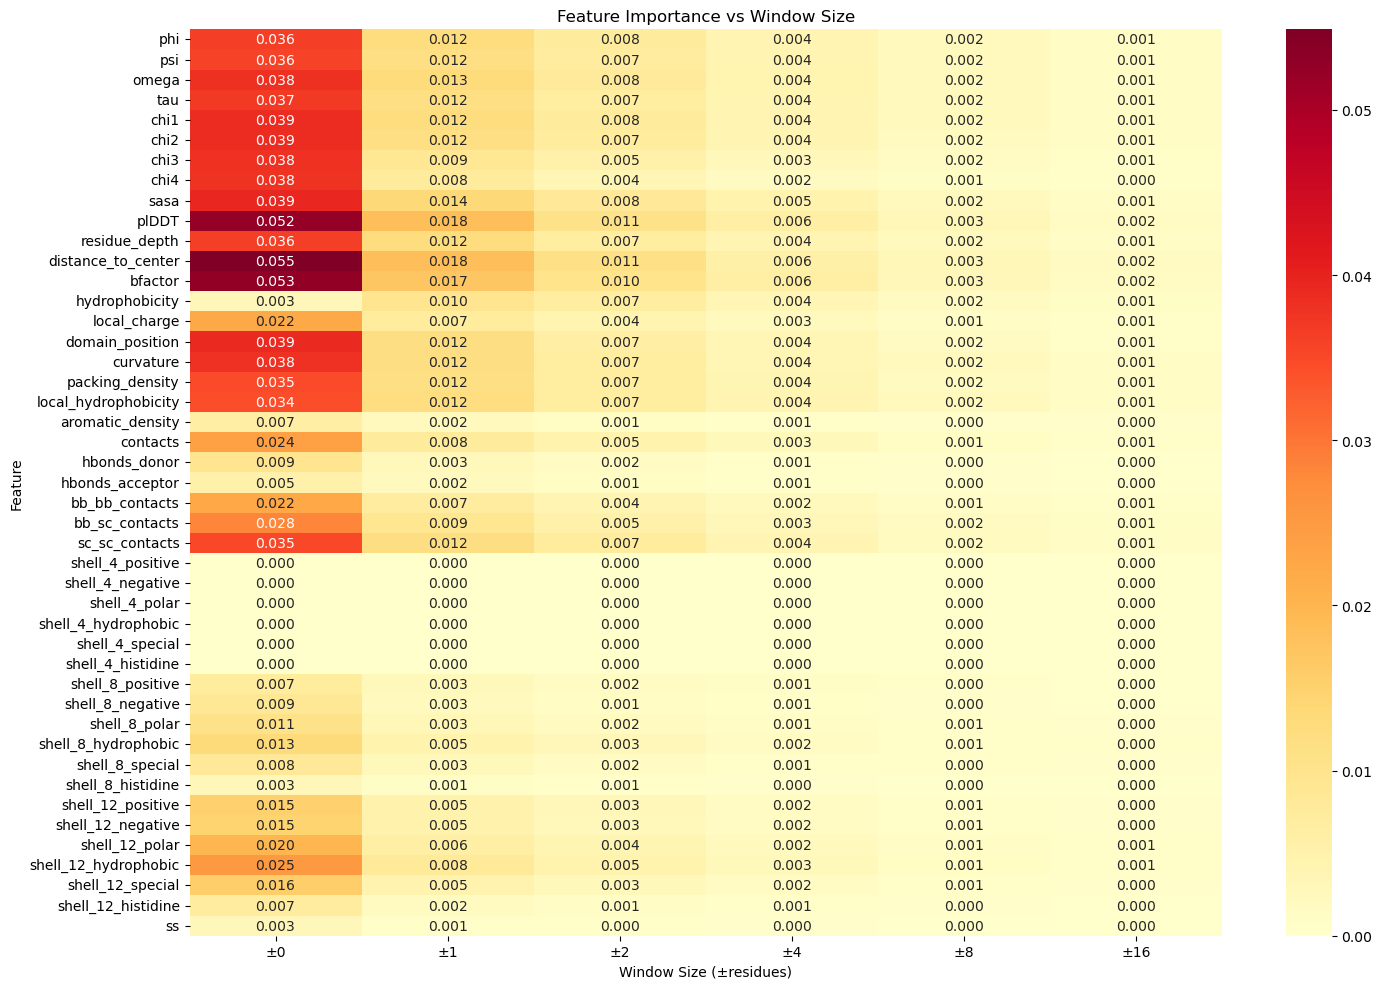

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Print basic statistics about labels in training set
print("Training Set Label Distribution:")
print(train_df['label'].value_counts())
print("\nPercentage:")
print(train_df['label'].value_counts(normalize=True) * 100)

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance
# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]

# Find optimal window size for each feature
optimal_windows = {}
for feature in results_df.index:
    best_window = results_df.loc[feature].idxmax()
    best_importance = results_df.loc[feature].max()
    optimal_windows[feature] = (best_window, best_importance)

# Sort features by importance
sorted_features = sorted(optimal_windows.items(), key=lambda x: x[1][1], reverse=True)

# Print recommendations
print("\nRecommended window sizes for each feature (sorted by importance):")
print("\nFeature | Optimal Window | Importance")
print("-" * 50)
for feature, (window, importance) in sorted_features:
    print(f"{feature:<30} | {window:<13} | {importance:.4f}")

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]  # Removed plDDT

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate feature importance for different window sizes
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]

# Find optimal window size for each feature
optimal_windows = {}
for feature in results_df.index:
    best_window = results_df.loc[feature].idxmax()
    best_importance = results_df.loc[feature].max()
    optimal_windows[feature] = (best_window, best_importance)

# Sort features by importance
sorted_features = sorted(optimal_windows.items(), key=lambda x: x[1][1], reverse=True)

# Print recommendations
print("\nRecommended window sizes for each feature (sorted by importance):")
print("\nFeature | Optimal Window | Importance")
print("-" * 50)
for feature, (window, importance) in sorted_features:
    print(f"{feature:<30} | {window:<13} | {importance:.4f}")

Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16

Recommended window sizes for each feature (sorted by importance):

Feature | Optimal Window | Importance
--------------------------------------------------
bfactor                        | ±0            | 0.0667
distance_to_center             | ±0            | 0.0580
sasa                           | ±0            | 0.0417
omega                          | ±0            | 0.0407
domain_position                | ±0            | 0.0406
chi2                           | ±0            | 0.0400
residue_depth                  | ±0            | 0.0398
chi1                           | ±0            | 0.0398
chi4                           | ±0            | 0.0397
chi3                           | ±0            | 0.0390
curvature                      | ±0            | 0.0387
psi                            | ±0            | 0.0383
phi           

Reading data from: /Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/training codes/data/old data/processed_data_train_after.csv
Processing window size ±0
[LightGBM] [Info] Number of positive: 4592, number of negative: 4258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 8850, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518870 -> initscore=0.075516
[LightGBM] [Info] Start training from score 0.075516
Processing window size ±1
[LightGBM] [Info] Number of positive: 4592, number of negative: 4258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6903
[LightGBM] [Info] Number of data points in the train set:

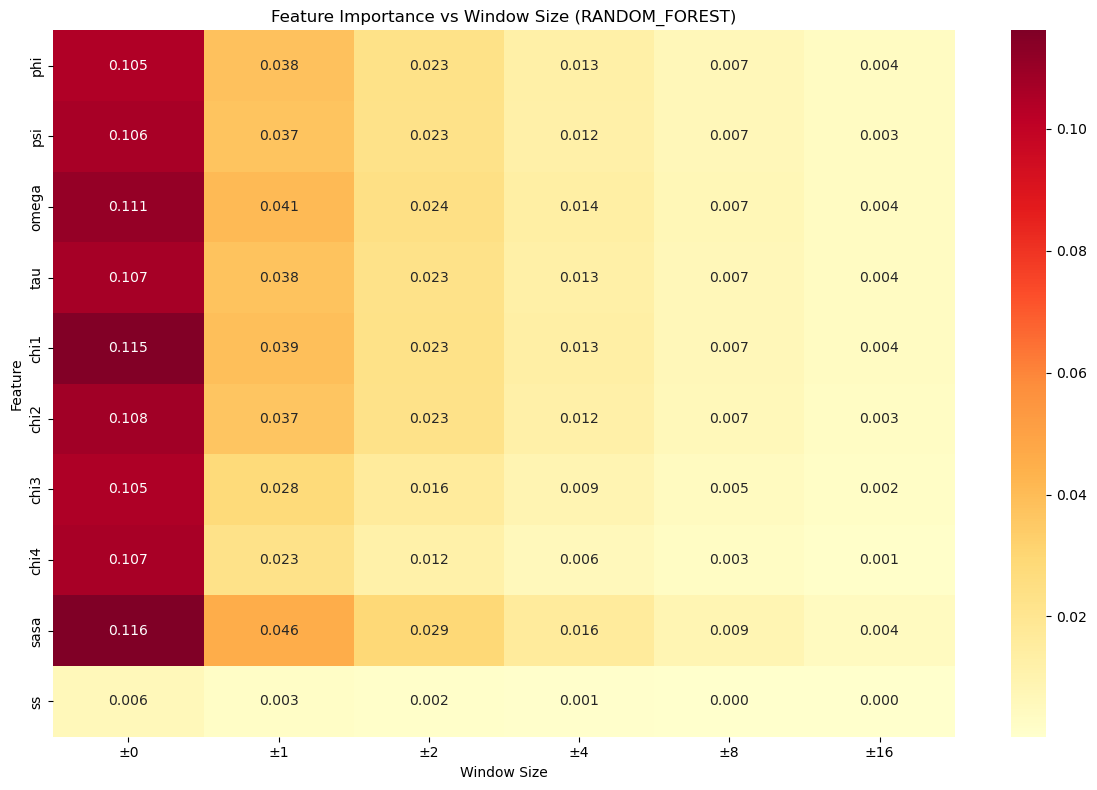


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

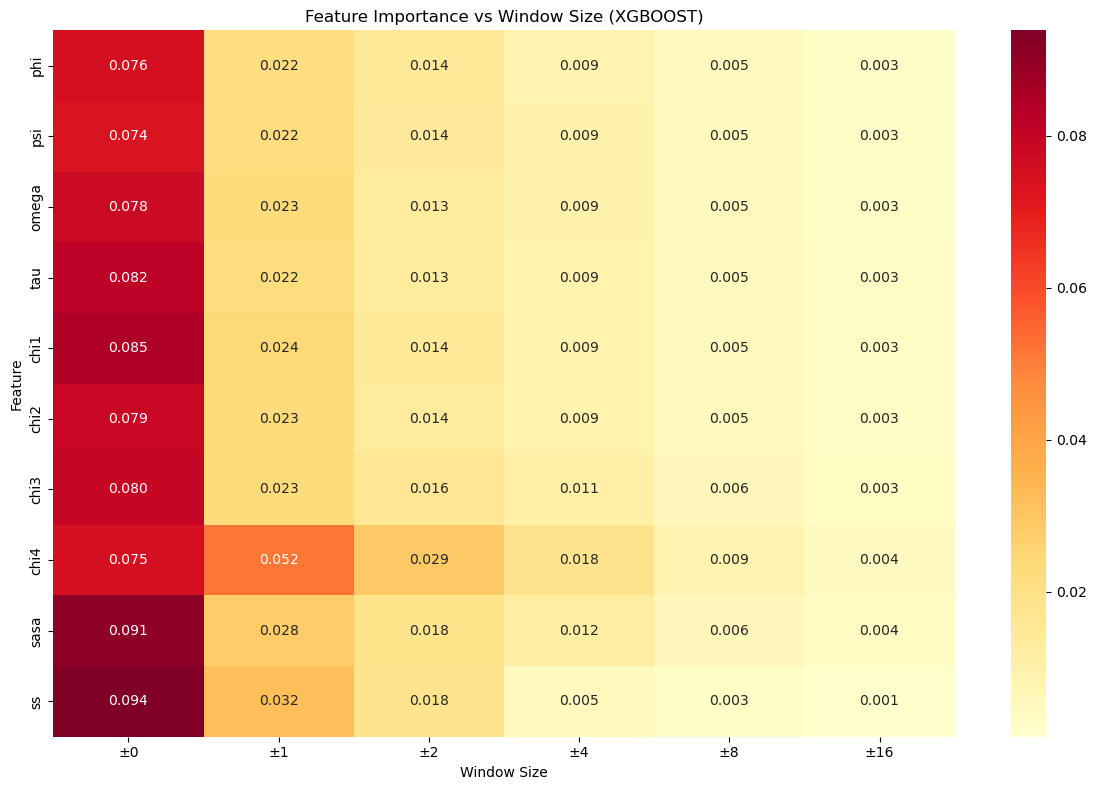


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

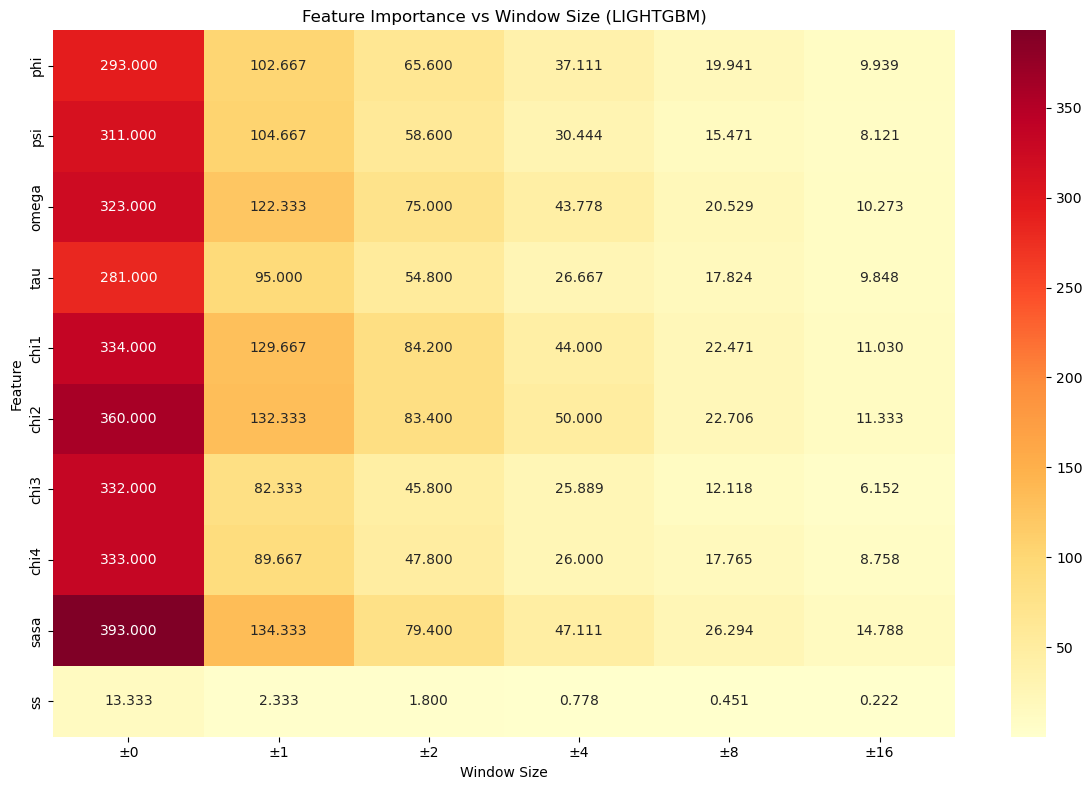


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

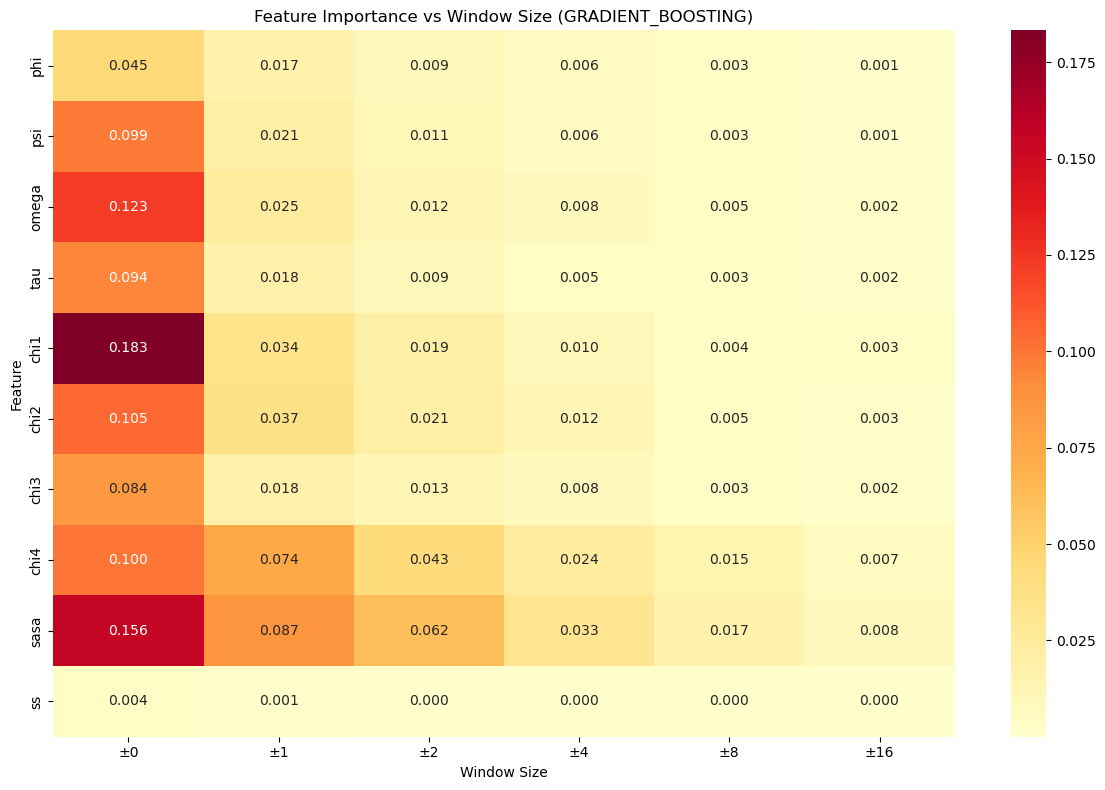


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

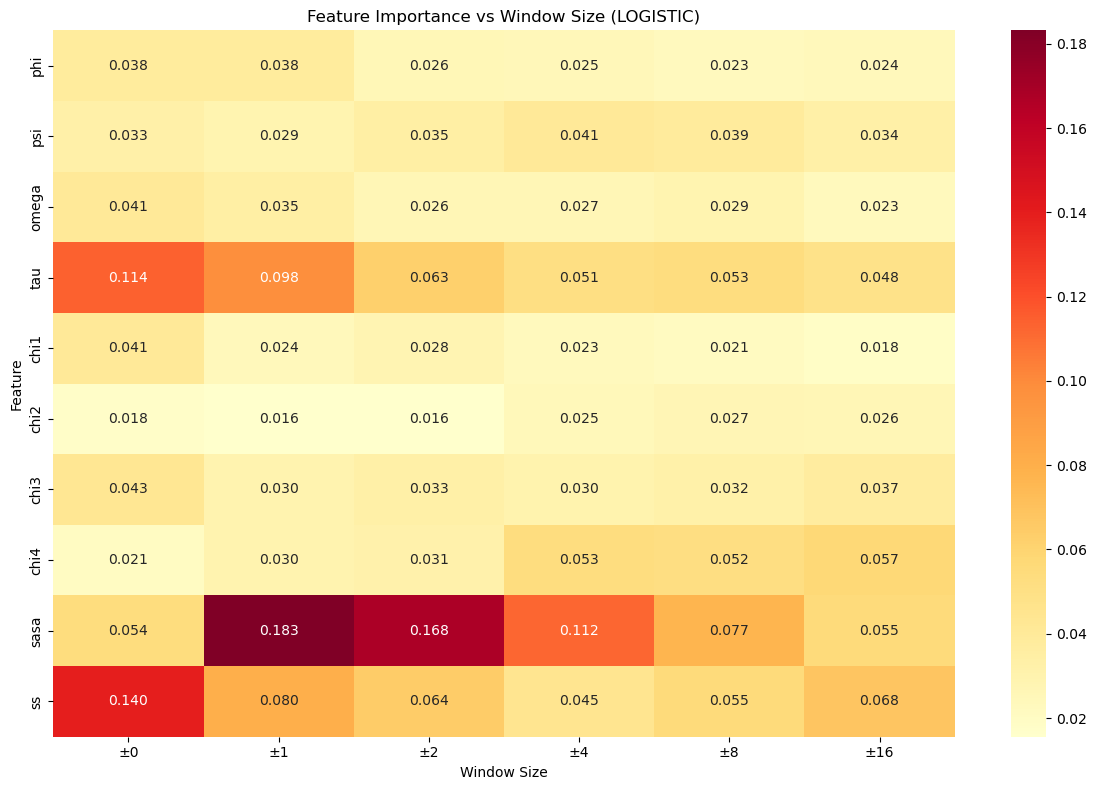


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

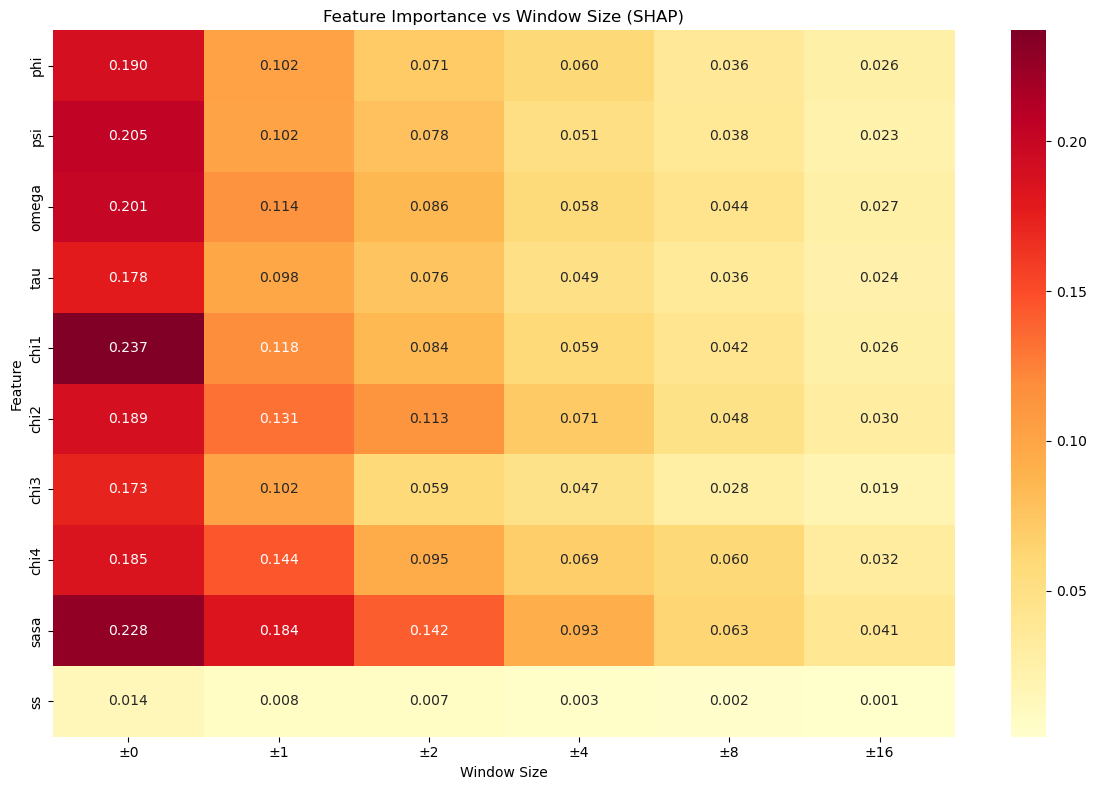


Analysis Report:
# Feature Importance Analysis Report

## Overall Summary by Window Size


### Window Size ±0

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.116), xgboost (0.091), lightgbm (393.000), gradient_boosting (0.156), logistic (0.054), shap (0.228)

- chi1: Found in 5 models: random_forest (0.115), xgboost (0.085), lightgbm (334.000), gradient_boosting (0.183), shap (0.237)

- omega: Found in 2 models: random_forest (0.111), gradient_boosting (0.123)

- ss: Found in 2 models: xgboost (0.094), logistic (0.140)


### Window Size ±1

Top features by importance across models:

- sasa: Found in 6 models: random_forest (0.046), xgboost (0.028), lightgbm (134.333), gradient_boosting (0.087), logistic (0.183), shap (0.184)

- chi1: Found in 2 models: random_forest (0.039), lightgbm (129.667)

- chi4: Found in 3 models: xgboost (0.052), gradient_boosting (0.074), shap (0.144)

- ss: Found in 2 models: xgboost (0.032), logistic (0.080)

- chi2: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
import shap

class FeatureImportanceAnalyzer:
    def __init__(self, continuous_features, discrete_features):
        self.continuous_features = continuous_features
        self.discrete_features = discrete_features
        self.models = {
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42),
            'xgboost': xgb.XGBClassifier(n_estimators=100, random_state=42),
            'lightgbm': lgb.LGBMClassifier(n_estimators=100, random_state=42),
            'gradient_boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
            'logistic': LogisticRegression(max_iter=1000, random_state=42)
        }
        
    def prepare_data(self, df, window_size, middle_pos=16):
        X_processed = []
        feature_names = []
        
        # Process continuous features
        scaler = StandardScaler()
        for feature in self.continuous_features:
            positions = list(range(middle_pos-window_size, middle_pos+window_size+1))
            for pos in positions:
                values = np.array([x[pos] for x in df[feature].values])
                mask = values != 0
                if mask.any():
                    non_zero_values = values[mask].reshape(-1, 1)
                    values[mask] = scaler.fit_transform(non_zero_values).flatten()
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-middle_pos}")
        
        # Process SS
        encoder = OneHotEncoder(sparse_output=False)
        positions = list(range(middle_pos-window_size, middle_pos+window_size+1))
        for pos in positions:
            ss_values = np.array([x[pos] for x in df['ss'].values]).reshape(-1, 1)
            encoded_ss = encoder.fit_transform(ss_values)
            for i, ss_type in enumerate(encoder.categories_[0]):
                X_processed.append(encoded_ss[:, i])
                feature_names.append(f"ss_{ss_type}_{pos-middle_pos}")
        
        X = np.array(X_processed).T
        y = df['label'].values
        
        return X, y, feature_names
    
    def get_model_importance(self, model_name, X, y, feature_names):
        model = self.models[model_name]
        model.fit(X, y)
        
        if model_name == 'logistic':
            importance = np.abs(model.coef_[0])
        else:
            importance = model.feature_importances_
            
        return importance
    
    def get_shap_importance(self, X, y, feature_names):
        model = xgb.XGBClassifier(n_estimators=100, random_state=42)
        model.fit(X, y)
        
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        return np.abs(shap_values).mean(axis=0)
    
    def analyze_all_models(self, df, window_size):
        X, y, feature_names = self.prepare_data(df, window_size)
        
        results = {}
        # Get importance from each model
        for model_name in self.models.keys():
            importance = self.get_model_importance(model_name, X, y, feature_names)
            results[model_name] = self.aggregate_importance(importance, feature_names)
            
        # Add SHAP importance
        try:
            shap_importance = self.get_shap_importance(X, y, feature_names)
            results['shap'] = self.aggregate_importance(shap_importance, feature_names)
        except Exception as e:
            print(f"SHAP analysis failed: {e}")
            
        return results
    
    def aggregate_importance(self, importance, feature_names):
        feature_importance = {}
        for feat_type in self.continuous_features + ['ss']:
            if feat_type == 'ss':
                mask = [f.startswith('ss_') for f in feature_names]
            else:
                mask = [f.startswith(feat_type + '_') for f in feature_names]
            importance_values = importance[mask]
            feature_importance[feat_type] = np.mean(importance_values)
        return feature_importance

def generate_analysis_report(all_results, window_sizes, results_dir):
    """Generate a comprehensive text report of the feature importance analysis"""
    report = []
    report.append("# Feature Importance Analysis Report\n")
    
    # Overall summary for each window size
    report.append("## Overall Summary by Window Size\n")
    for size in window_sizes:
        report.append(f"\n### Window Size ±{size}\n")
        model_results = {}
        
        # Collect results from all models for this window size
        for model_name, results in all_results[size].items():
            sorted_features = sorted(results.items(), key=lambda x: x[1], reverse=True)
            model_results[model_name] = sorted_features
        
        # Find consensus top features
        all_top_features = {}
        for model_name, sorted_features in model_results.items():
            for feature, importance in sorted_features[:3]:  # Top 3 features
                if feature not in all_top_features:
                    all_top_features[feature] = []
                all_top_features[feature].append((model_name, importance))
        
        # Report consensus findings
        report.append("Top features by importance across models:\n")
        for feature, appearances in all_top_features.items():
            if len(appearances) > 1:  # Feature appears in multiple models
                model_list = [f"{model} ({importance:.3f})" for model, importance in appearances]
                report.append(f"- {feature}: Found in {len(appearances)} models: {', '.join(model_list)}\n")
    
    # Model-specific analysis
    report.append("\n## Model-Specific Analysis\n")
    for model_name in all_results[0].keys():  # Use first window size to get model names
        report.append(f"\n### {model_name.upper()} Analysis\n")
        
        # Track feature importance trends across window sizes
        feature_trends = {}
        for size in window_sizes:
            results = all_results[size][model_name]
            for feature, importance in results.items():
                if feature not in feature_trends:
                    feature_trends[feature] = []
                feature_trends[feature].append(importance)
        
        # Analyze trends
        for feature, trends in feature_trends.items():
            optimal_size = window_sizes[np.argmax(trends)]
            max_importance = max(trends)
            trend_description = "increases" if trends[-1] > trends[0] else "decreases"
            
            report.append(f"\n{feature}:\n")
            report.append(f"- Optimal window size: ±{optimal_size}\n")
            report.append(f"- Maximum importance: {max_importance:.3f}\n")
            report.append(f"- Trend: Importance {trend_description} with window size\n")
    
    # Feature-specific insights
    report.append("\n## Feature-Specific Insights\n")
    features = list(all_results[0][list(all_results[0].keys())[0]].keys())
    for feature in features:
        report.append(f"\n### {feature}\n")
        
        # Collect importance across all models and window sizes
        importances = []
        for size in window_sizes:
            for model_name in all_results[size].keys():
                importances.append(all_results[size][model_name][feature])
        
        avg_importance = np.mean(importances)
        std_importance = np.std(importances)
        
        report.append(f"- Average importance across all models and windows: {avg_importance:.3f} (±{std_importance:.3f})\n")
        
        # Find best model and window size for this feature
        best_importance = 0
        best_model = ""
        best_size = 0
        for size in window_sizes:
            for model_name in all_results[size].keys():
                importance = all_results[size][model_name][feature]
                if importance > best_importance:
                    best_importance = importance
                    best_model = model_name
                    best_size = size
        
        report.append(f"- Best performance: {best_importance:.3f} with {best_model} at window size ±{best_size}\n")
    
    # Save report
    report_path = os.path.join(results_dir, 'feature_importance_report.md')
    with open(report_path, 'w') as f:
        f.writelines(report)
    
    return '\n'.join(report)

def analyze_features(train_df_path):
    # Define features
    continuous_features = [
        'phi', 'psi', 'omega', 'tau', 
        'chi1', 'chi2', 'chi3', 'chi4',
        'sasa'
    ]
    discrete_features = ['ss']
    
    # Initialize analyzer
    analyzer = FeatureImportanceAnalyzer(continuous_features, discrete_features)
    
    # Read data
    train_df_path = os.path.abspath(os.path.expanduser(train_df_path))
    print(f"Reading data from: {train_df_path}")
    train_df = pd.read_csv(train_df_path)
    
    # Process features
    processed_df = pd.DataFrame()
    processed_df['label'] = train_df['label']
    
    def process_feature(df, feature_name):
        if feature_name == 'ss':
            return df[feature_name].apply(list)
        else:
            return df[feature_name].apply(lambda x: 
                np.array([float(v.strip()) for v in x.strip('[]').split(',')]))
    
    for feature in continuous_features:
        processed_df[feature] = process_feature(train_df, feature)
    processed_df['ss'] = train_df['ss'].apply(list)
    
    # Analyze with different window sizes
    window_sizes = [0, 1, 2, 4, 8, 16]
    all_results = {}
    
    for size in window_sizes:
        print(f"Processing window size ±{size}")
        results = analyzer.analyze_all_models(processed_df, size)
        all_results[size] = results
    
    # Create results directory
    results_dir = 'feature_importance_results'
    os.makedirs(results_dir, exist_ok=True)
    
# Create comparison visualizations
    model_names = list(analyzer.models.keys()) + ['shap']  # Convert dict_keys to list first
    
    for model_name in model_names:
        try:
            results_df = pd.DataFrame({
                size: results[model_name] 
                for size, results in all_results.items()
            })
            results_df.columns = [f'±{size}' for size in window_sizes]
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
            plt.title(f'Feature Importance vs Window Size ({model_name.upper()})')
            plt.xlabel('Window Size')
            plt.ylabel('Feature')
            plt.tight_layout()
            # plt.savefig(os.path.join(results_dir, f'feature_importance_heatmap_{model_name}.png'))
            # plt.close()
            plt.show()
            
            # Save numerical results
            results_df.to_csv(os.path.join(results_dir, f'feature_importance_{model_name}.csv'))
            
        except KeyError as e:
            print(f"Skipping {model_name} visualization due to missing results")
            continue
        
        # Save numerical results
        results_df.to_csv(os.path.join(results_dir, f'feature_importance_{model_name}.csv'))
    
        # Generate and save analysis report
        report = generate_analysis_report(all_results, window_sizes, results_dir)
        print("\nAnalysis Report:")
        print(report)
    return all_results, report

# Usage
if __name__ == "__main__":
    results, report = analyze_features('../data/old data/processed_data_train_after.csv')